# Domain Decomposition Method for coupling the NSWE and the Serre equations

It's exactly the same as in the horizontal case, except that the initial solution is $h-d_0$ instead of $h$.

In [194]:
import sys

sys.path.append('../Serre')
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import generalFunctions as gF
import muscl2
import nswe_wbmuscl4 as wb4
import serre
import serreTBC
import cnoidal
import DDM_nswe_serre as ddmNS

%matplotlib inline

In [195]:
## Parameters and variables used in all the simulations

In [237]:

## with this configuration, the NSWE breaks the wave in two waves travelling in opposite senses (????)
a0 = 1.
a1 = .1
k = 0.
g = 9.81
t0 = 0.0
t = t0
tmax = 3.
dt = 0.05

lam, h0 = cnoidal.WaveLengthDepth(k,a0,a1)

L = 3*lam
xmin = -L
xmax = L
nx = 300

dx1 = (xmax-xmin)/(nx)

x,dx = serre.discretizeSpace(xmin-3.*dx1,xmax+3.*dx1,nx+6)
dx = np.diff(x)[0]

H = 2.
Hh = .1

## BOTTOM
eta = 0.01
#Lslope1 = xmin+50*dx
#Lslope2 = xmax-50.*dx
#d0 = np.where(x<Lslope1, h0-H, np.where(x>Lslope2,h0-Hh,h0-H + (x-Lslope1)/(-Lslope1+Lslope2)*(H-Hh)))
d0 = h0 - Hh + eta*(x-xmax)

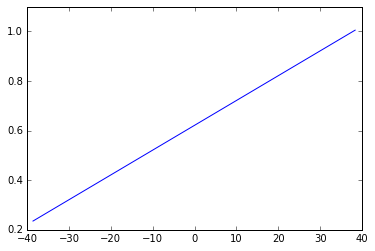

In [238]:
plt.plot(x,d0)

In [239]:
## NSWE in monodomain
reload(serre)
reload(ddmNS)

h,u = cnoidal.analyticalSolutionSolitary(x[3:-3],t,a0,a1)
h = serre.extend2GhostCells(h,3)
u = serre.extend2GhostCells(u,3)
h = h-d0

print(x.size,h.size,u.size)
hall,uall,tall = serre.NSWE(x,h,u,t0,tmax,ddmNS.openDomainThreeGC,None,dx,x.size,vardt = False, dt = dt,
                              fvsolver=ddmNS.fluxes, ghostcells=3,fvTimesolver=serre.Euler)

umin = np.amin(uall)
umax = np.amax(uall)
hmin = np.amin(hall)
hmax = np.amax(hall)

## store referential solution
xM = np.copy(x)
uallM = np.copy(uall)
hallM = np.copy(hall)
tallM = np.copy(tall)

(306, 306, 306)
CFL = 3.110601


In [240]:
## FOR PRINTING
### store d0 for all instants
### add d0 to h to obtain the surface elevation

hallMP = np.copy(hall)
d0all = np.copy(hall)

for i in range (tall.size):
    d0all[:,i] = d0
    hallMP[:,i] = hallM[:,i] + d0

*** Plotting animation ...



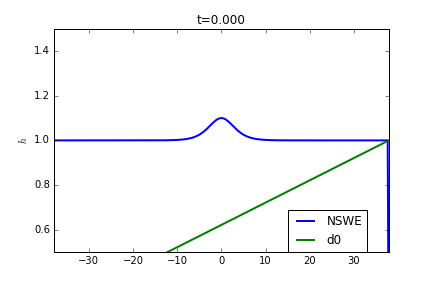
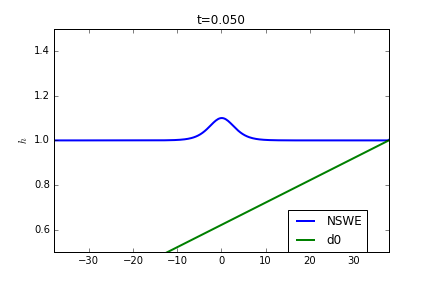
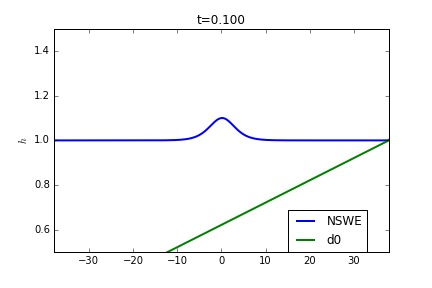
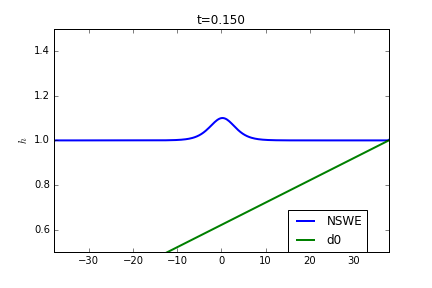
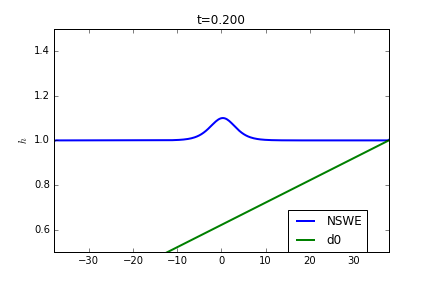
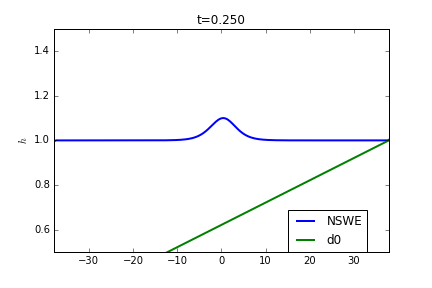
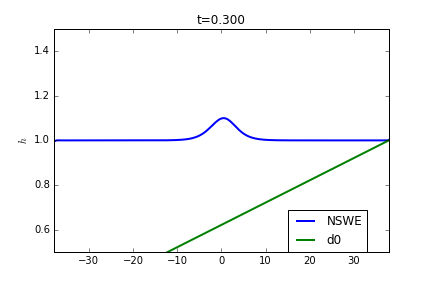
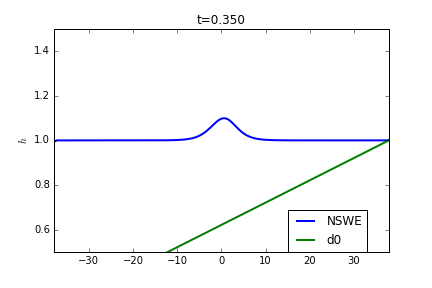
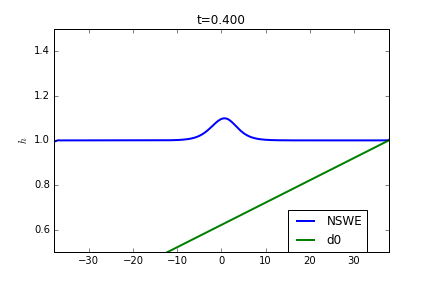
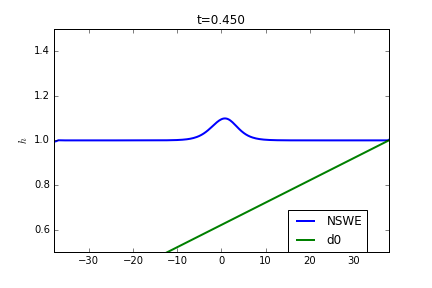
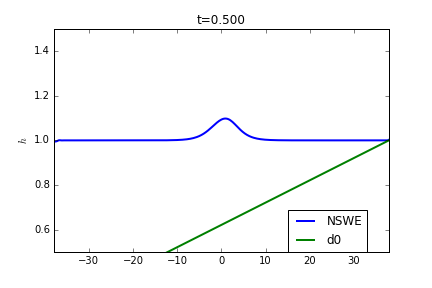
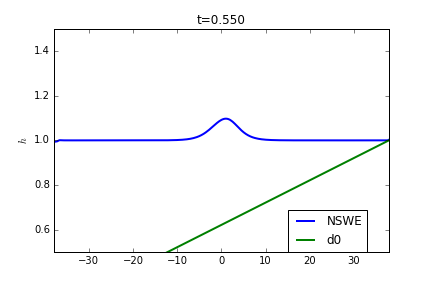
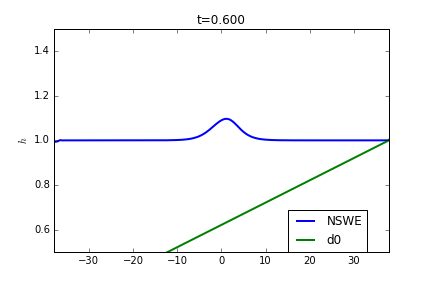
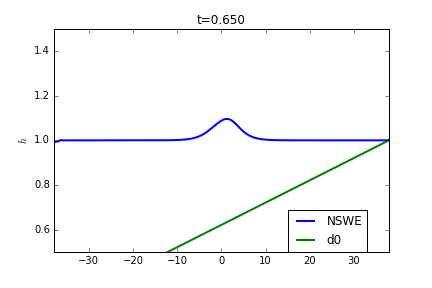
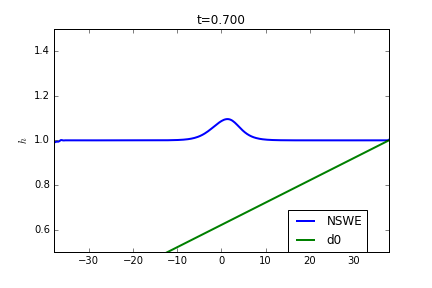
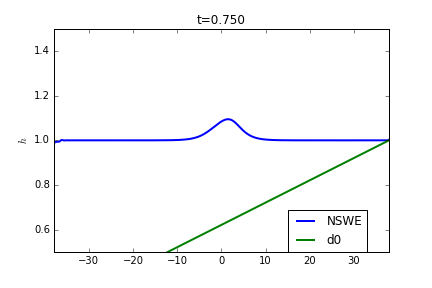
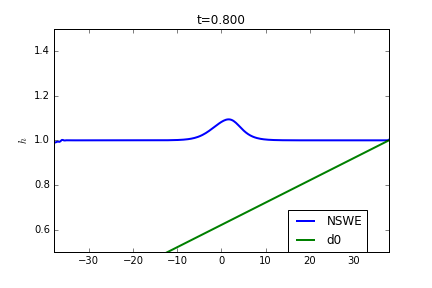
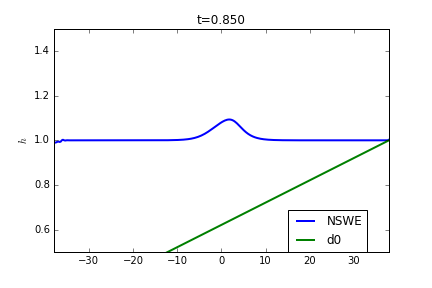
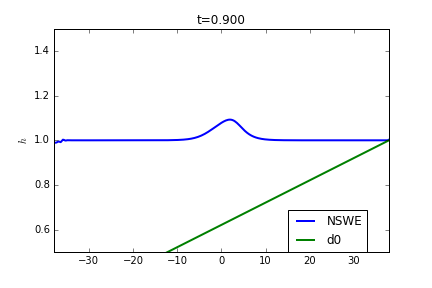
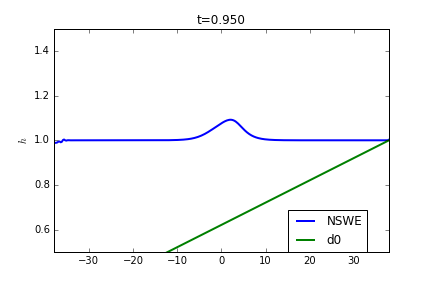
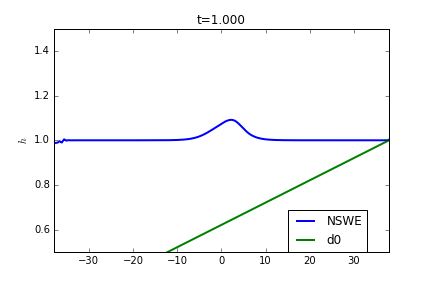
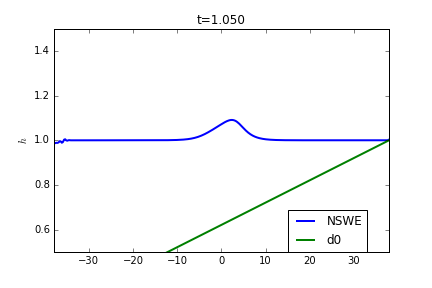
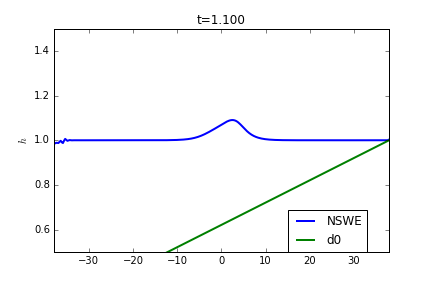
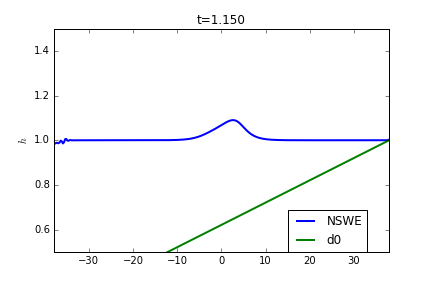
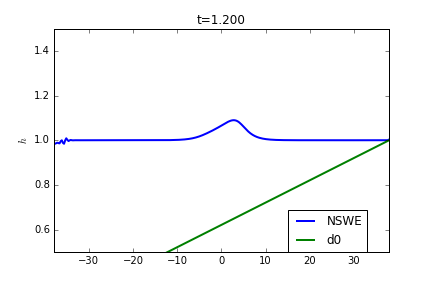
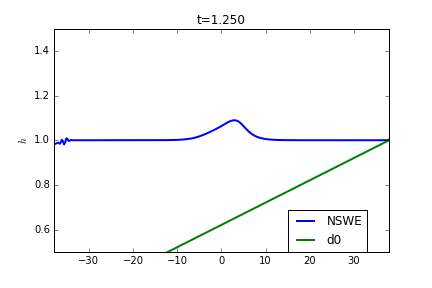
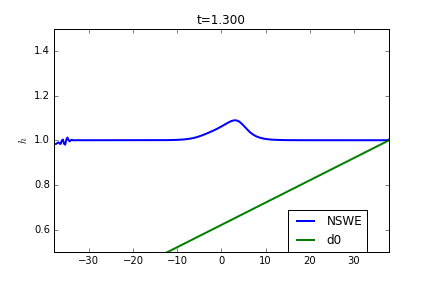
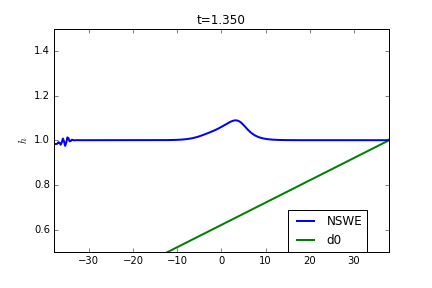
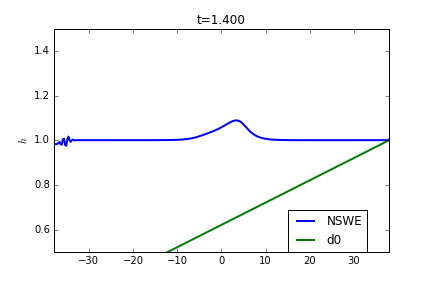
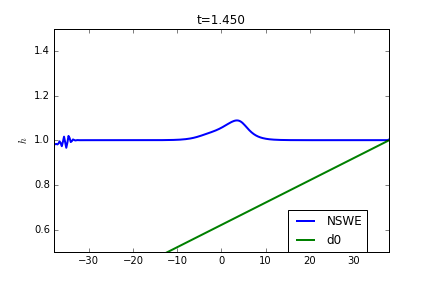
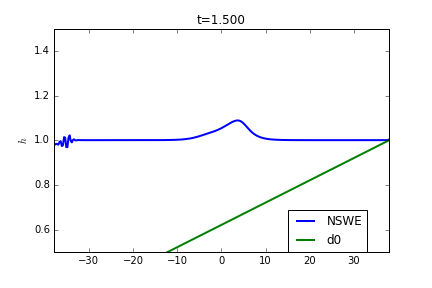
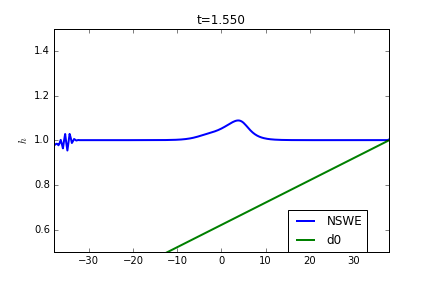
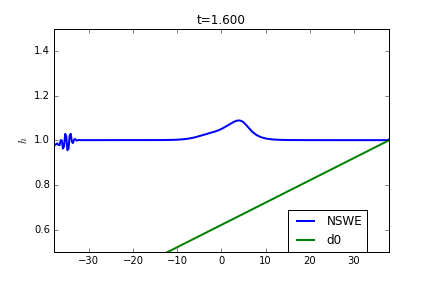
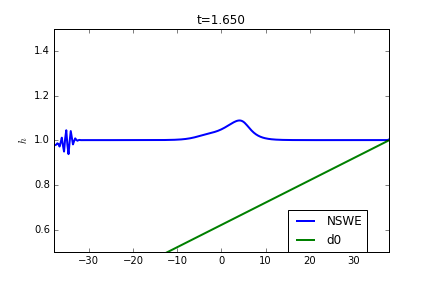
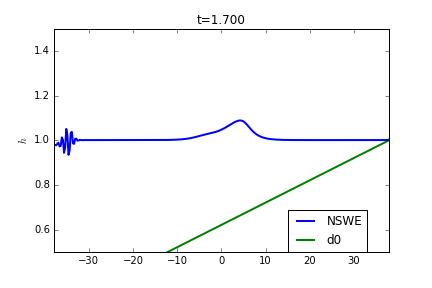
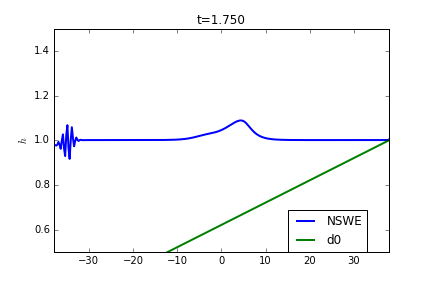
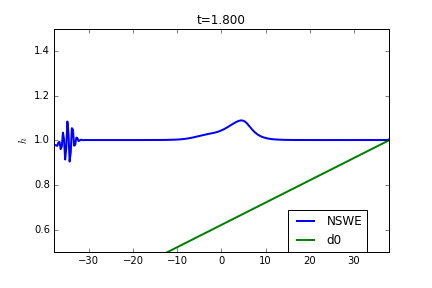
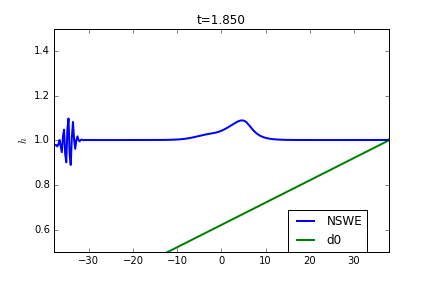
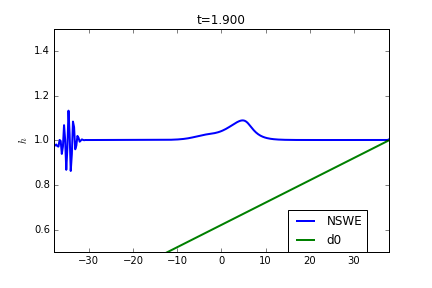
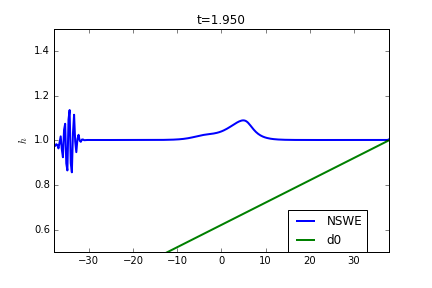
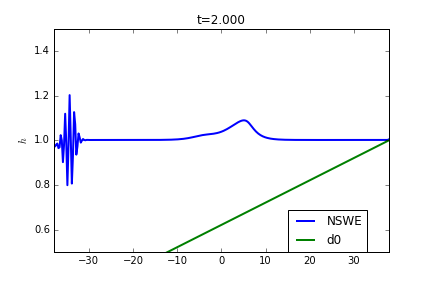
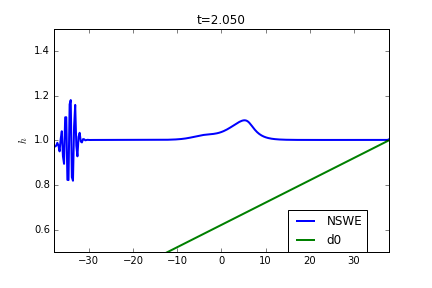
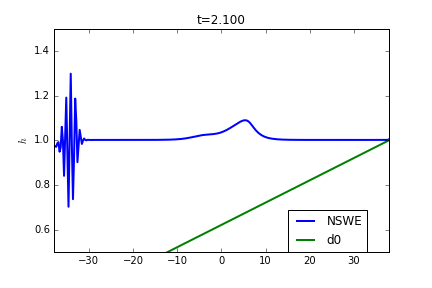
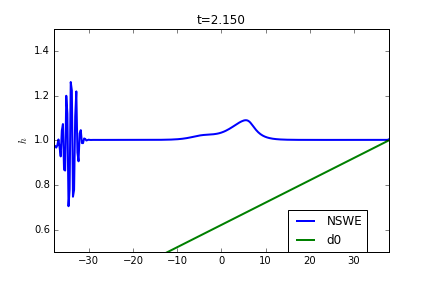
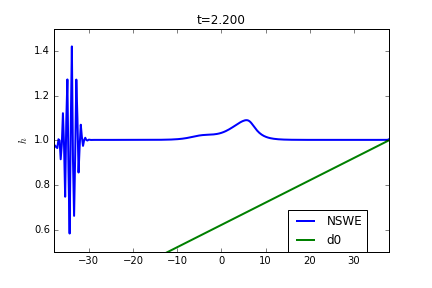
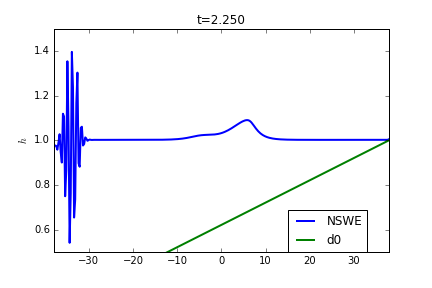
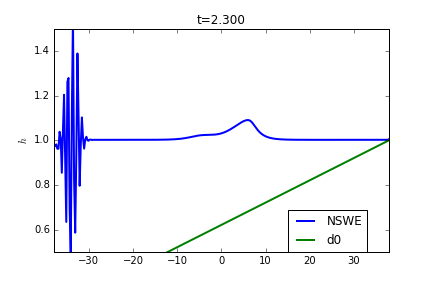
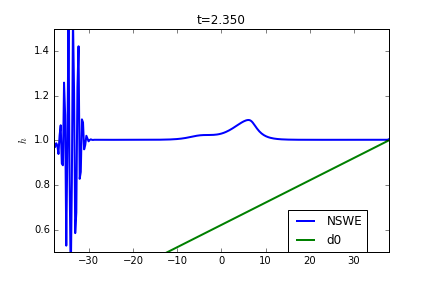
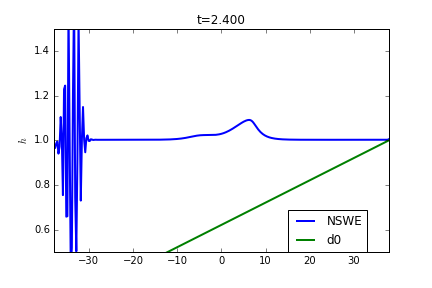
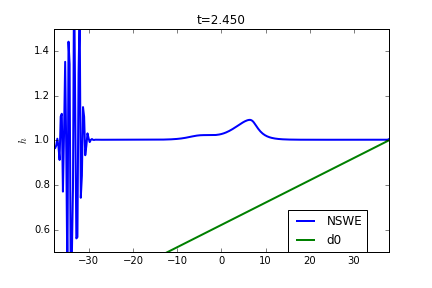
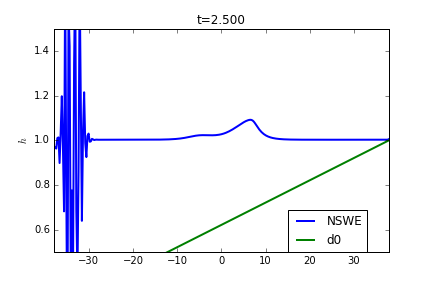
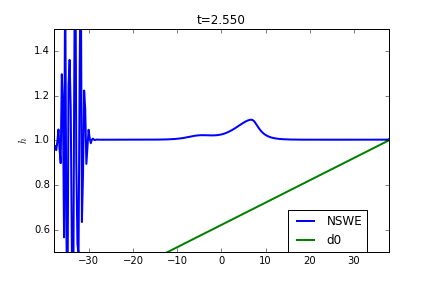
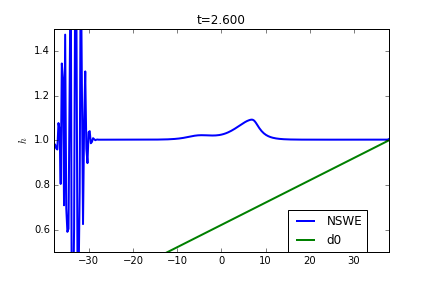
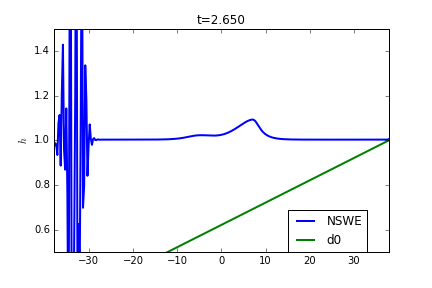
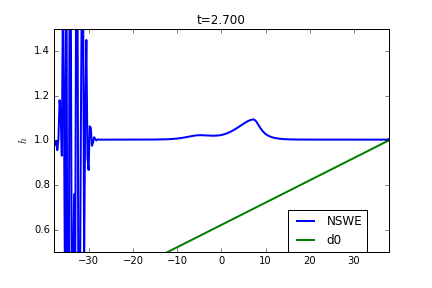
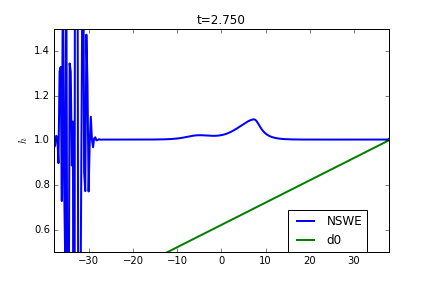
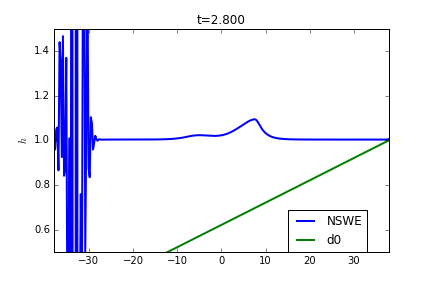
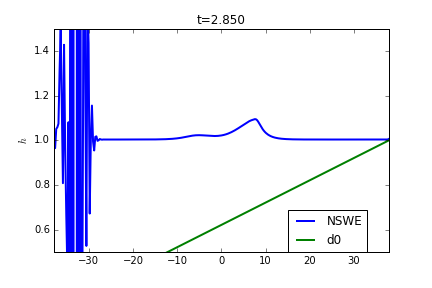
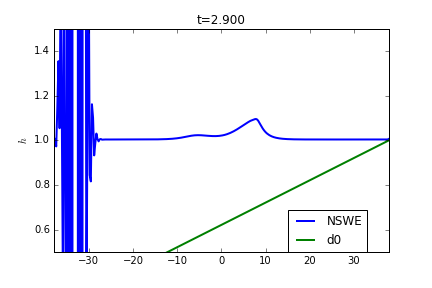
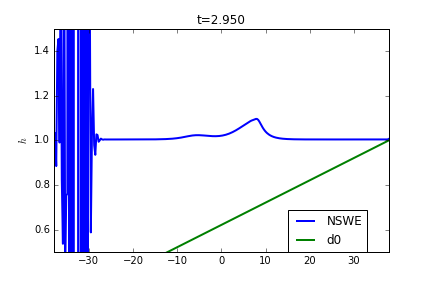
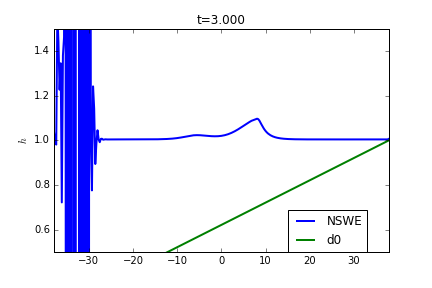
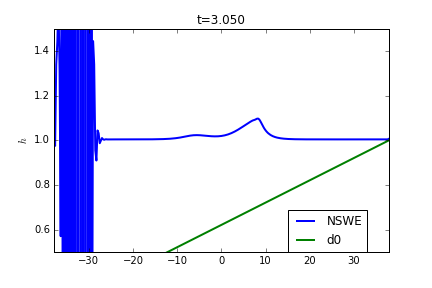

In [241]:
lb = ["NSWE", "d0"]
gF.plotAnimationNSolutions(2,x,np.array([hallMP,d0all]),tallM,xmin,xmax,0.5,1.5,lb,ylabel=r'$h$',location=(0.7,0.))

## Commentaries
* Problem in the boundary (probably linked with the end of the slope)
* Also tried a bottom with the shape _/¨, but the discontinuities in the slope produce strong instabilities
* To try a smoother bottom (e.g. atan)

*** Plotting animation ...



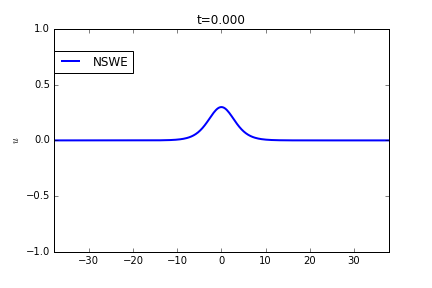
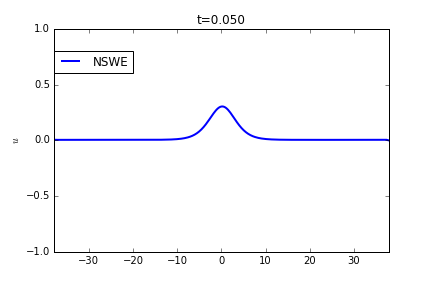
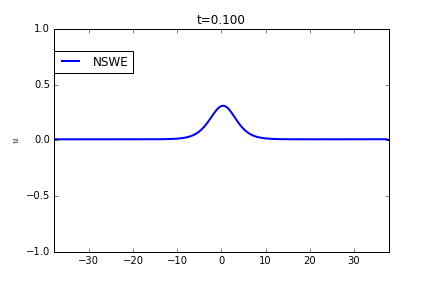
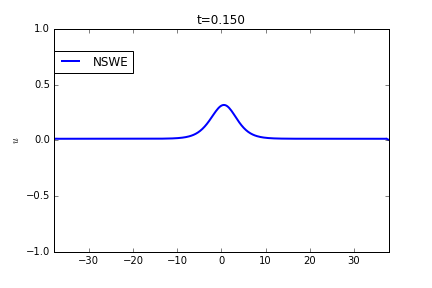
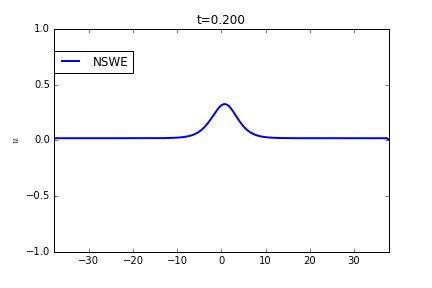
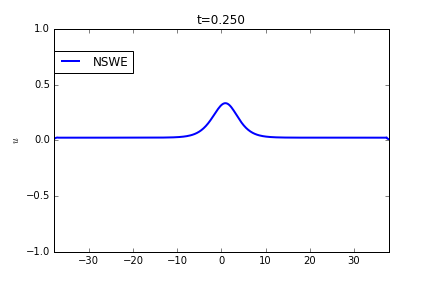
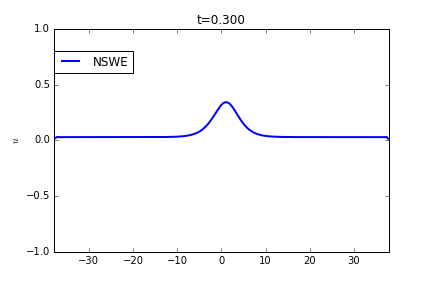
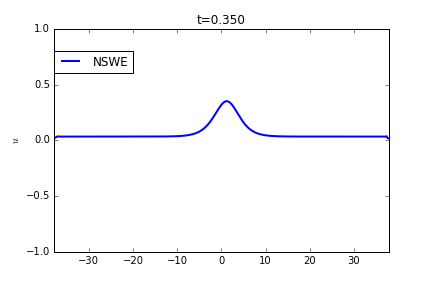
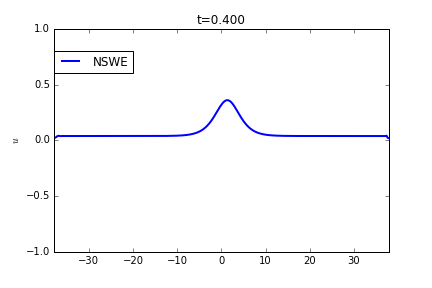
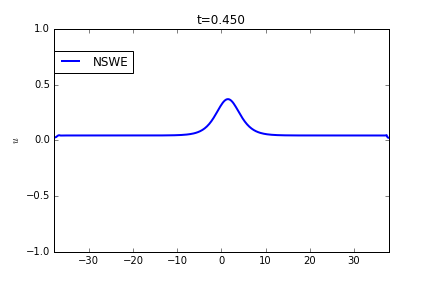
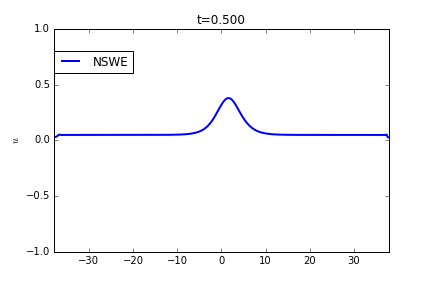
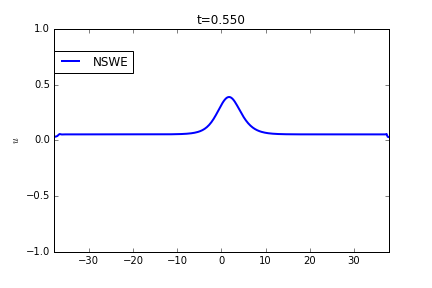
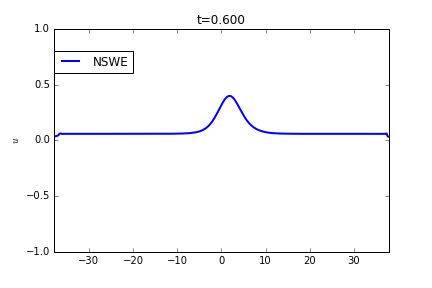
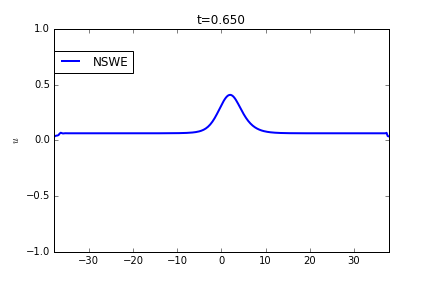
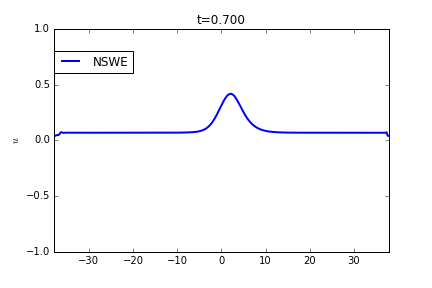
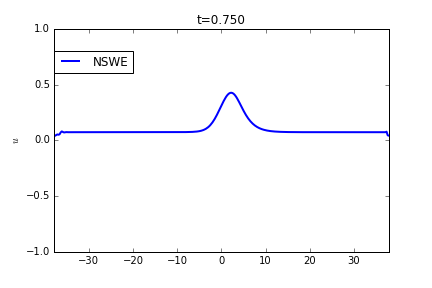
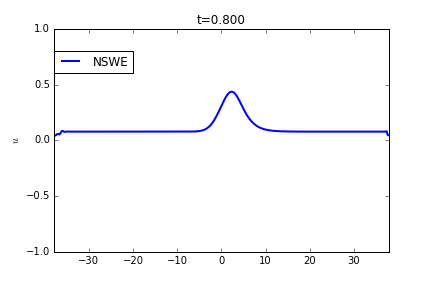
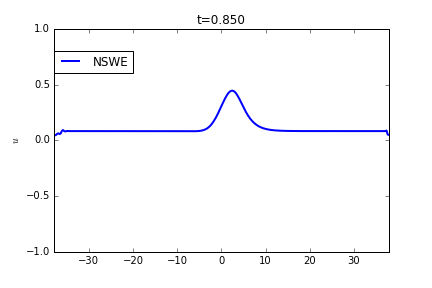
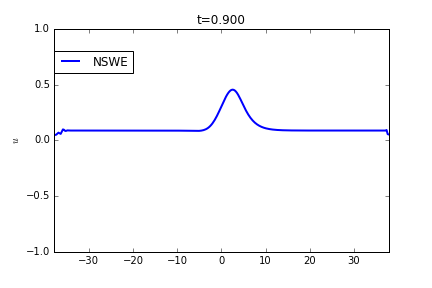
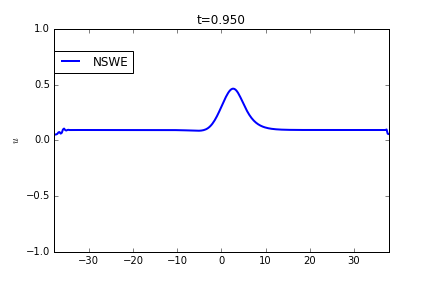
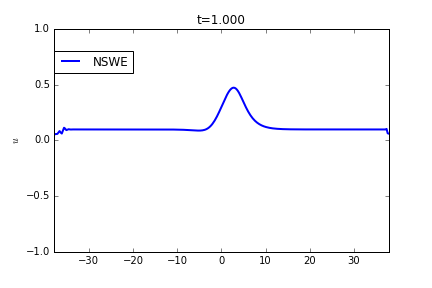
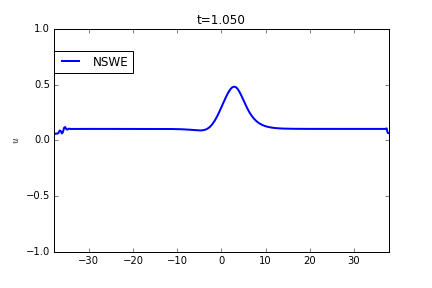
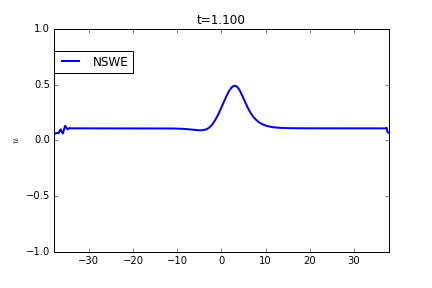
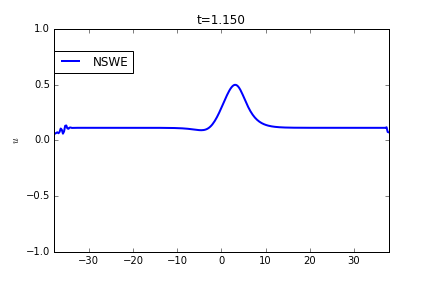
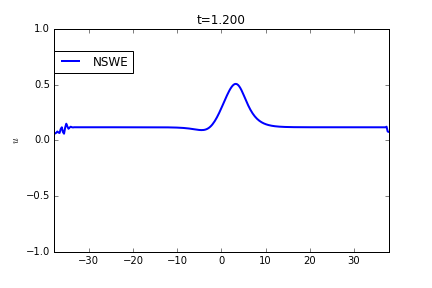
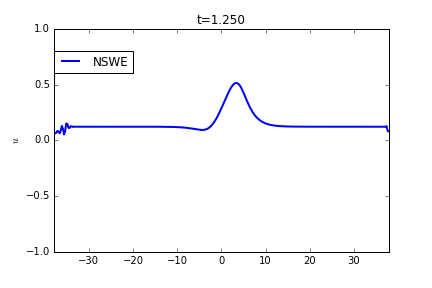
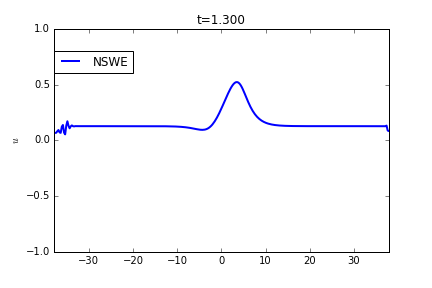
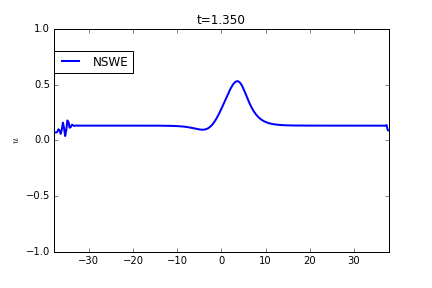
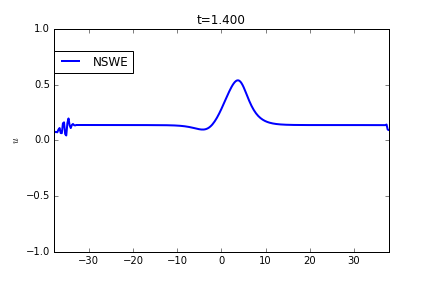
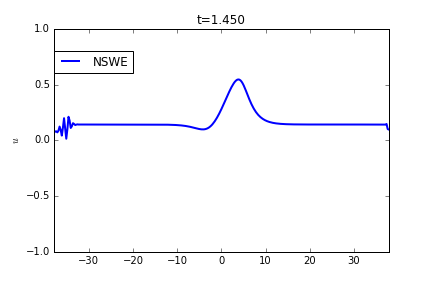
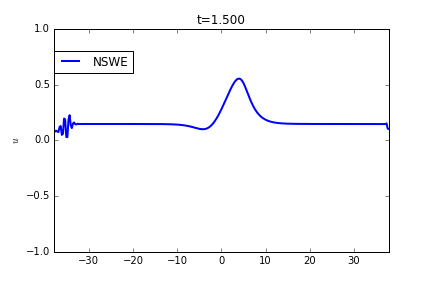
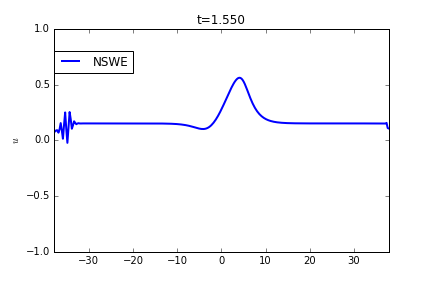
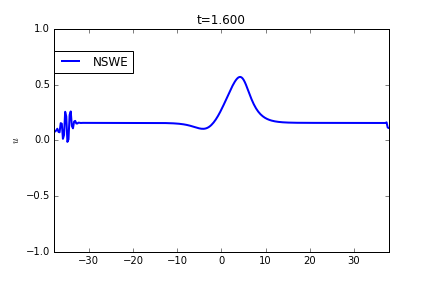
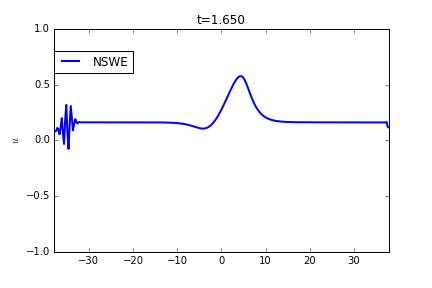
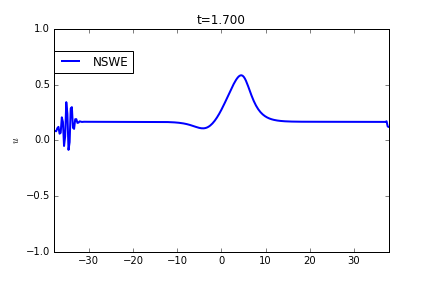
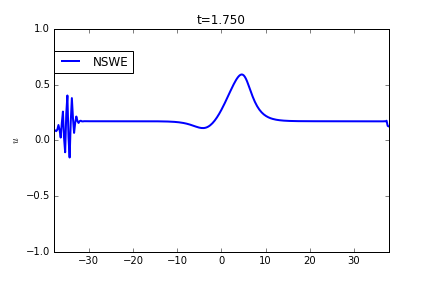
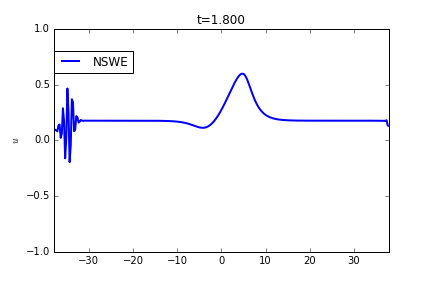
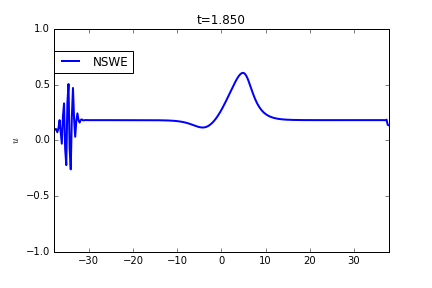
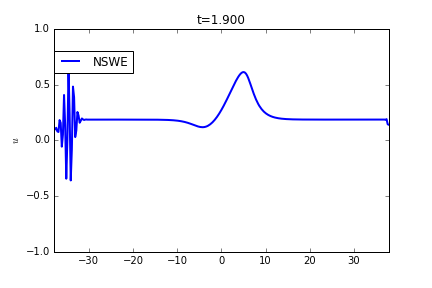
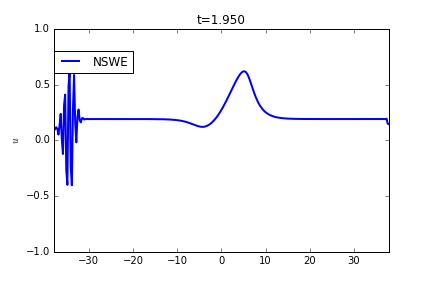
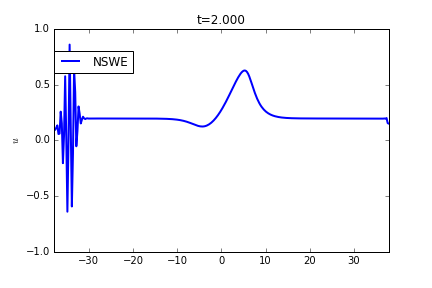
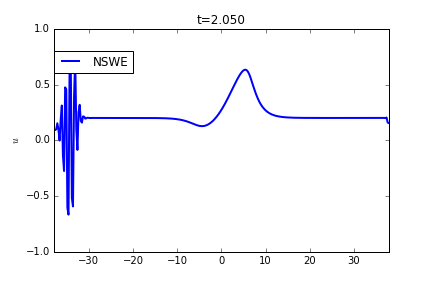
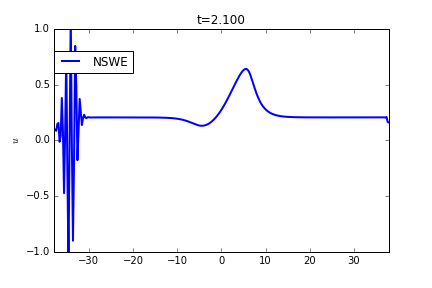
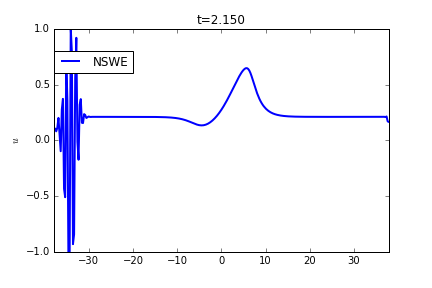
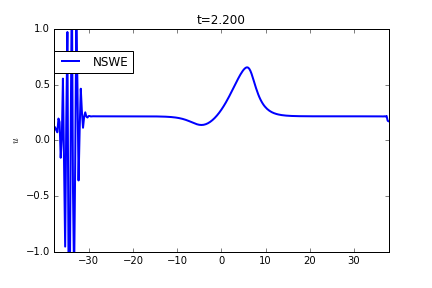
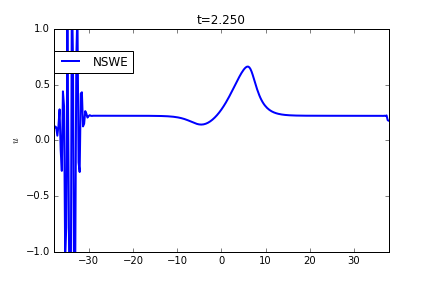
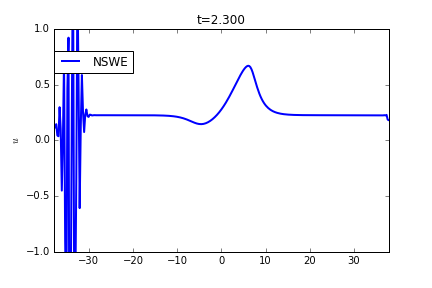
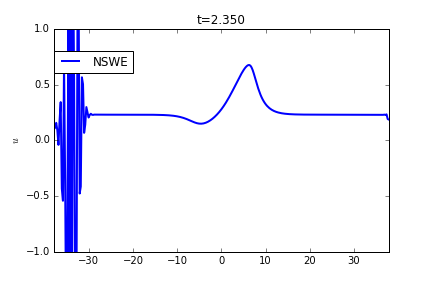
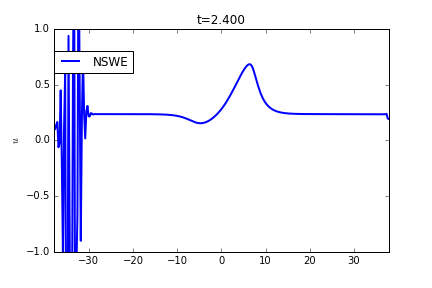
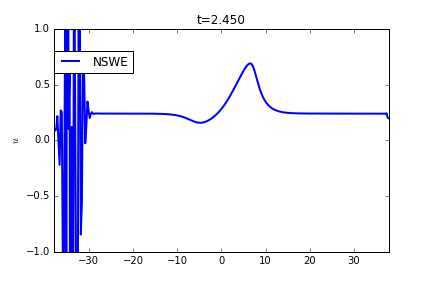
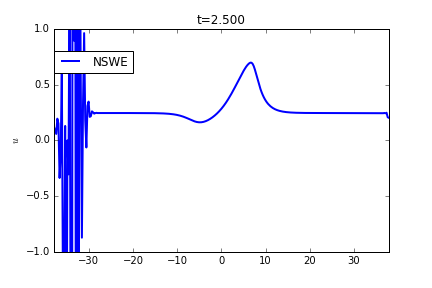
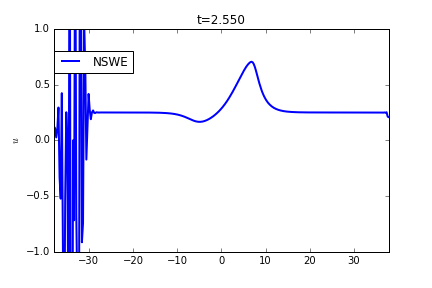
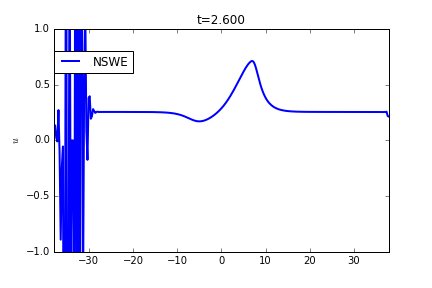
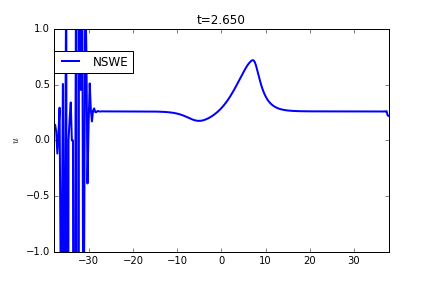
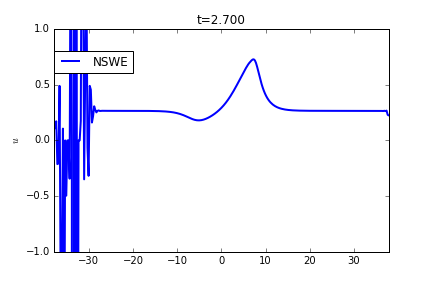
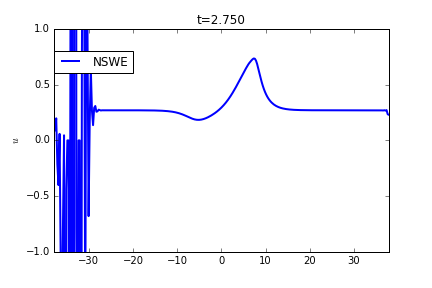
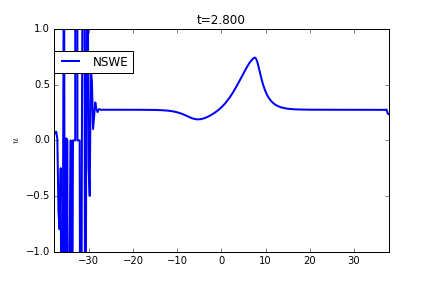
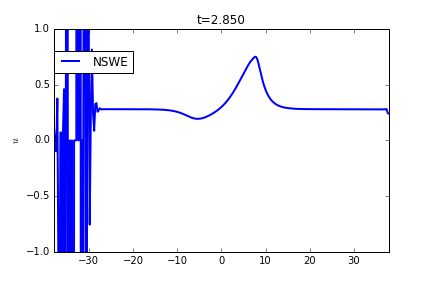
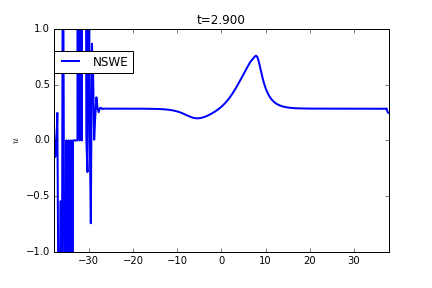
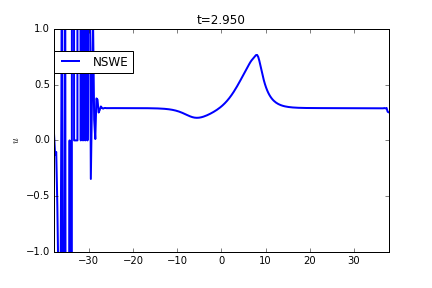
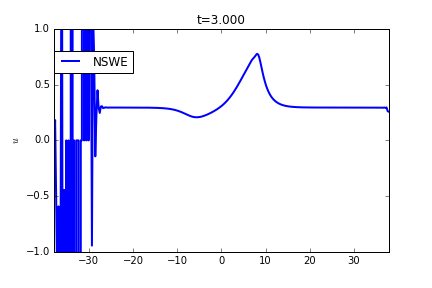
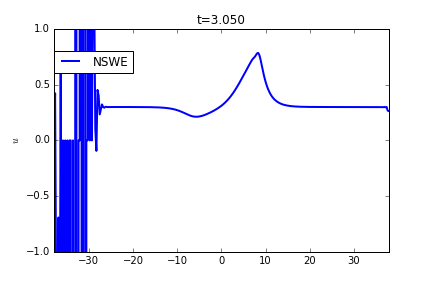

In [242]:
lb = ["NSWE", "d0"]
gF.plotAnimationNSolutions(1,x,np.array([uallM]),tallM,xmin,xmax,-1.,1.,lb,ylabel=r'$u$',location=(0.,0.8))

## Commentaries
* Velocity in all the domain growing with the same rate --> ??

## DDM with overlapping 

In [231]:
### Only NSWE

In [243]:
## DDM

Nddm = x.size/2
print(x.size)
print(x[Nddm:Nddm+3])

print(x[Nddm],Nddm)
configDDM = 2 ## With overtlapping
#overlapping size
ov = 0 ## ov = 0: 1 cell overlapped

if configDDM == 1:
    x1 = x[0:Nddm+3] ## (0:Nddm+1) + 3 gc 
    x2 = x[Nddm-3:] ## 3gc + (Nddm:)
    h1 = h[0:Nddm+3]
    h2 = h[Nddm-3:]
    u1 = u[0:Nddm+3]
    u2 = u[Nddm-3:]
elif configDDM == 2:
    x1 = x[0:Nddm+4+ov] ## (0:Nddm+1) + 3 gc + ov
    x2 = x[Nddm-3-ov:] ## ov + 3gc + (Nddm:)
    h1 = h[0:Nddm+4+ov]
    h2 = h[Nddm-3-ov:]
    u1 = u[0:Nddm+4+ov]
    u2 = u[Nddm-3-ov:]

## TBC for dispersive equation
## in right domain

print(x1[-3]-x2[4+2*ov],x2[0]-x1[-7-2*ov])



hall1,uall1,tall1,hall2,uall2,tall2 = ddmNS.DDM_NSWE(x1,h1,u1,x2,h2,u2,t0,tmax,ddmNS.DDM_BCs,dx,nx+6,
             dt = dt, fvsolver=ddmNS.fluxes,
             ghostcells = 3, externalBC="open",coupleSerre=False,nitermax=1,configDDM=configDDM,ov=ov,uref=uallM,
                                              href = hallM,xref=x,debug=False, fvTimesolver=serre.Euler)

umin = np.amin(uall1)
umax = np.amax(uall1)
hmin = np.amin(hall1)
hmax = np.amax(hall1)

### remove ghost cells for Printing
x1P = x1[3:-3]
x2P = x2[3:-3]

d0all1 = np.zeros_like(hall1)
d0all2 = np.zeros_like(hall2)
for i in range (tall1.size):
    d0all1[:x1.size,i] = d0[:x1.size]
    d0all2[:,i] = d0[x.size-x2.size:]    
    hall1[:,i] = hall1[:,i] + d0all1[:,i]
    hall2[:,i] = hall2[:,i] + d0all2[:,i]

d0all1P = d0all1[3:-3,:]
d0all2P = d0all2[3:-3,:]
uall1P = uall1[3:-3,:]
uall2P = uall2[3:-3,:]
hall1P = hall1[3:-3,:]
hall2P = hall2[3:-3,:]


306
[ 0.          0.25237244  0.50474487]
(4.0500935938325711e-13, 153)
(0.0, 0.0)

t = 0.050000
('Error wr to monodomain solution (Om1,Om2): ', 0.0, 0.0)


t = 0.100000
('Error wr to monodomain solution (Om1,Om2): ', 0.0, 0.0)


t = 0.150000
('Error wr to monodomain solution (Om1,Om2): ', 0.0, 0.0)


t = 0.200000
('Error wr to monodomain solution (Om1,Om2): ', 0.0, 0.0)


t = 0.250000
('Error wr to monodomain solution (Om1,Om2): ', 0.0, 0.0)


t = 0.300000
('Error wr to monodomain solution (Om1,Om2): ', 0.0, 0.0)


t = 0.350000
('Error wr to monodomain solution (Om1,Om2): ', 0.0, 0.0)


t = 0.400000
('Error wr to monodomain solution (Om1,Om2): ', 0.0, 0.0)


t = 0.450000
('Error wr to monodomain solution (Om1,Om2): ', 0.0, 0.0)


t = 0.500000
('Error wr to monodomain solution (Om1,Om2): ', 0.0, 0.0)


t = 0.550000
('Error wr to monodomain solution (Om1,Om2): ', 0.0, 0.0)


t = 0.600000
('Error wr to monodomain solution (Om1,Om2): ', 0.0, 0.0)


t = 0.650000
('Error wr to monodomain so

In [244]:
### NSWE + dispersive in the left (imposing continuity in interface)

In [245]:
reload(serreTBC)
reload(ddmNS)
## DDM

Nddm = x.size/2
print(x.size)
print(x[Nddm:Nddm+3])

ov = 0
configDDM = 2
if configDDM == 1:
    x1 = x[0:Nddm+3] ## (0:Nddm+1) + 3 gc 
    x2 = x[Nddm-3:] ## 3gc + (Nddm:)
    h1 = h[0:Nddm+3]
    h2 = h[Nddm-3:]
    u1 = u[0:Nddm+3]
    u2 = u[Nddm-3:]
elif configDDM == 2:
    x1 = x[0:Nddm+4+ov] ## (0:Nddm+1) + 3 gc + ov
    x2 = x[Nddm-3-ov:] ## ov + 3gc + (Nddm:)
    h1 = h[0:Nddm+4+ov]
    h2 = h[Nddm-3-ov:]
    u1 = u[0:Nddm+4+ov]
    u2 = u[Nddm-3-ov:]


c1 = 1.
c2 = 1.

lamb1 = c1
S1 = -c2-lamb1
P1 = 3*c2/(h0*h0*c1)    
    
serreDomain = 1
if serreDomain == 1:
    BCconfig = np.array([[0,"TBC",0.,0.,-1./lamb1,1.],
                             [1,"TBC",0.,-1./(lamb1*lamb1),0,1.],
                             [-1,"TBC",0.,P1,-S1,1.]])
else :
    BCconfig = np.array([[0,"TBC",0.,0.,-1./lamb1,1.],
                             [1,"TBC",0.,-1./(lamb1*lamb1),0,1.],
                             [-1,"TBC",0.,P1,-S1,1.]])
    
hall1DL,uall1DL,tall1DL,hall2DL,uall2DL,tall2DL = ddmNS.DDM_NSWE(x1,h1,u1,x2,h2,u2,t0,tmax,ddmNS.DDM_BCs,dx,nx,
             dt = dt, fvsolver=ddmNS.fluxes,
             ghostcells = 3, externalBC="open",coupleSerre=True,serreDomain=serreDomain,dispersiveBC=BCconfig,
             nitermax=1,configDDM=configDDM,ov=ov,fvTimesolver=serre.Euler,uref=uallM,
                                              href = hallM,xref=x,modifyIBC=True,eta=eta)

umin = np.amin(uall1)
umax = np.amax(uall1)
hmin = np.amin(hall1)
hmax = np.amax(hall1)

### remove ghost cells for Printing
x1DLP = x1[3:-3]
x2DLP = x2[3:-3]
uall1DLP = uall1DL[3:-3,:]
uall2DLP = uall2DL[3:-3,:]
hall1DLP = hall1DL[3:-3,:]
hall2DLP = hall2DL[3:-3,:]

306
[ 0.          0.25237244  0.50474487]


../Serre/serreTBC.py:283: RuntimeWarning: overflow encountered in multiply
  Q = 2.*h*hx*ux*ux + 4./3.*h*h*ux*uxx + eta*eta*h*u*ux + eta*eta*(hx+eta)*u*u
DDM_nswe_serre.py:298: RuntimeWarning: invalid value encountered in greater
  u1 = np.where(h1[:]>1e-5, hu1[:]/h1[:], 0.)
../Serre/serreTBC.py:283: RuntimeWarning: invalid value encountered in add
  Q = 2.*h*hx*ux*ux + 4./3.*h*h*ux*uxx + eta*eta*h*u*ux + eta*eta*(hx+eta)*u*u
../Serre/serreTBC.py:284: RuntimeWarning: overflow encountered in multiply
  rhs = gr*h*hx + h*Q + gr*h*eta
DDM_nswe_serre.py:299: RuntimeWarning: invalid value encountered in greater
  u2 = np.where(h2[:]>1e-5, hu2[:]/h2[:], 0.)


In [246]:
d0all1DL = np.zeros_like(hall1DL)
d0all2DL = np.zeros_like(hall2DL)
for i in range (tall1DL.size):
    d0all1DL[:x1.size,i] = d0[:x1.size]
    d0all2DL[:,i] = d0[x.size-x2.size:]    
    hall1DL[:,i] = hall1DL[:,i] + d0all1DL[:,i]
    hall2DL[:,i] = hall2DL[:,i] + d0all2DL[:,i]

d0all1DLP = d0all1DL[3:-3,:]
d0all2DLP = d0all2DL[3:-3,:]
uall1DLP = uall1DL[3:-3,:]
uall2DLP = uall2DL[3:-3,:]
hall1DLP = hall1DL[3:-3,:]
hall2DLP = hall2DL[3:-3,:]

*** Plotting animation ...



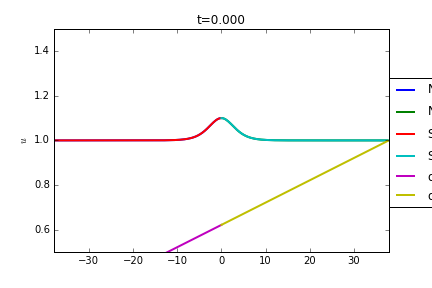
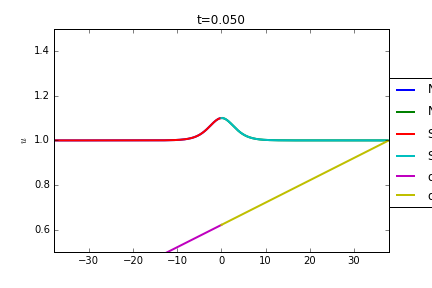
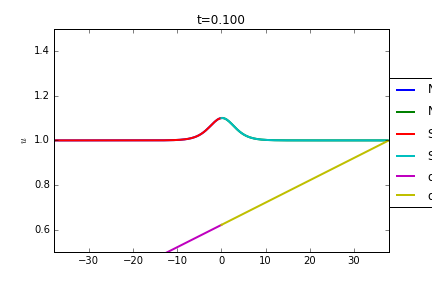
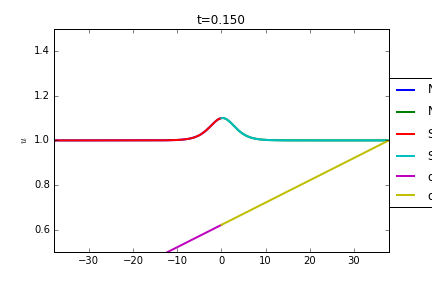
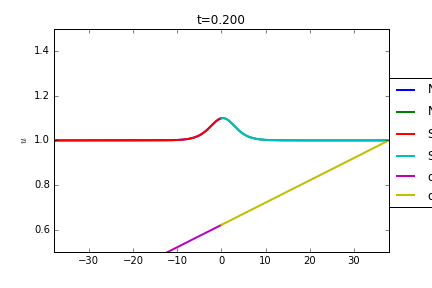
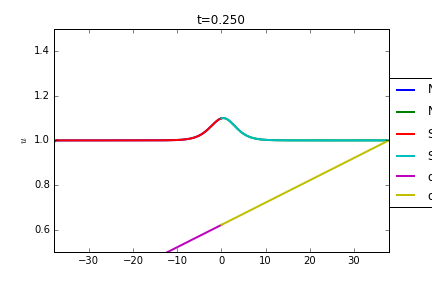
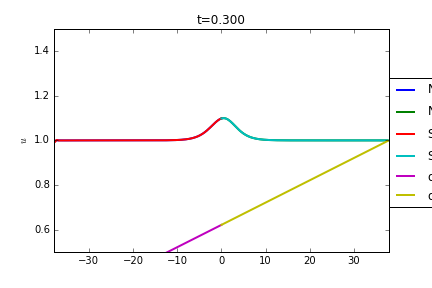
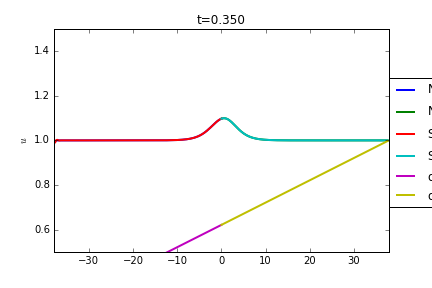
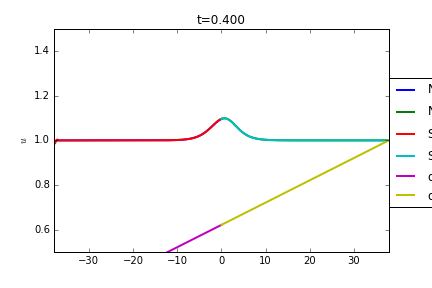
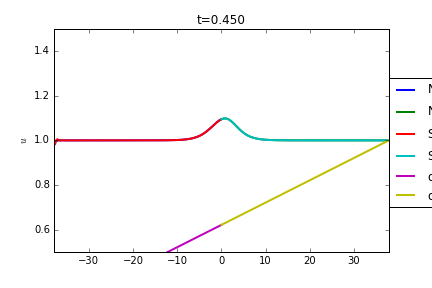
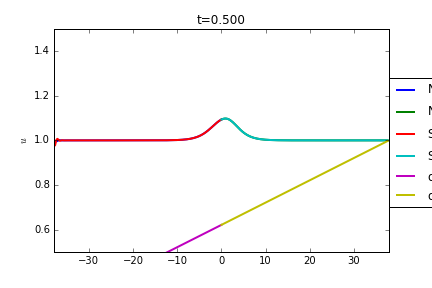
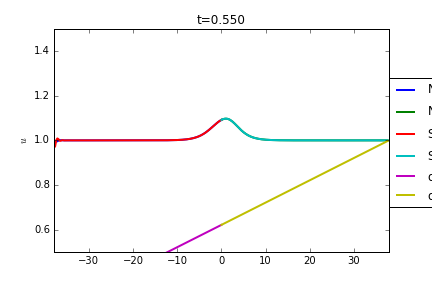
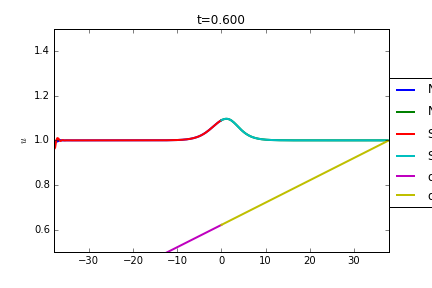
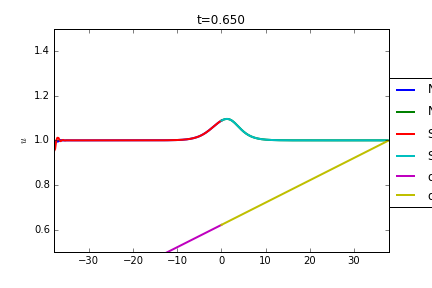
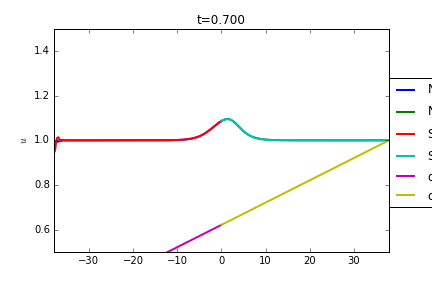
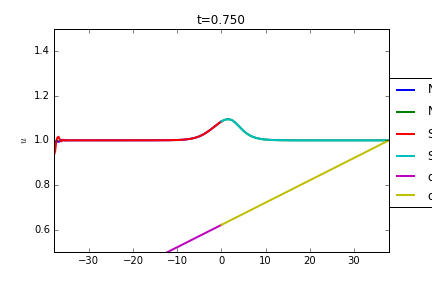
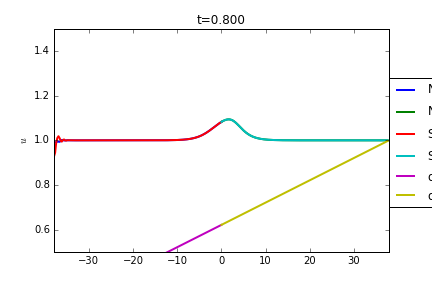
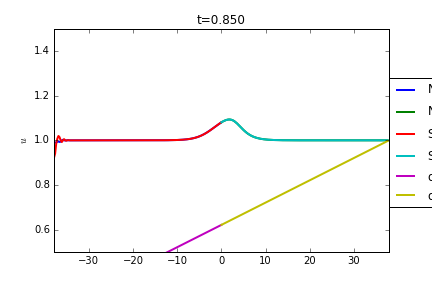
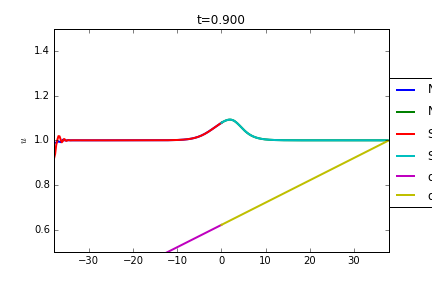
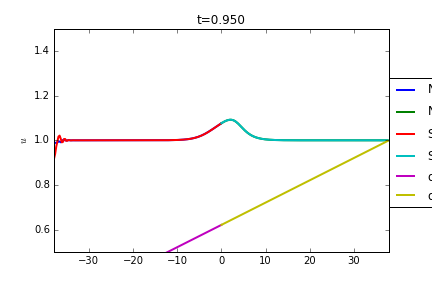
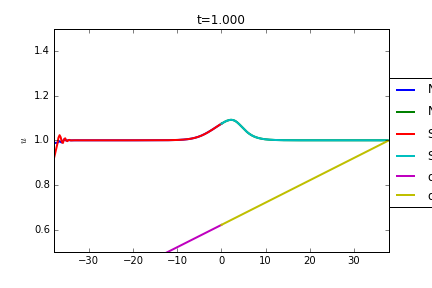
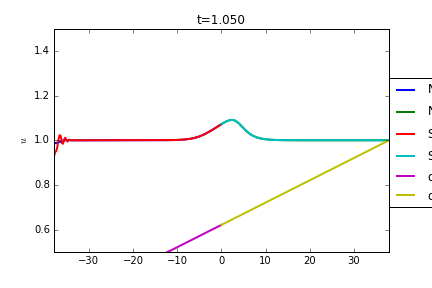
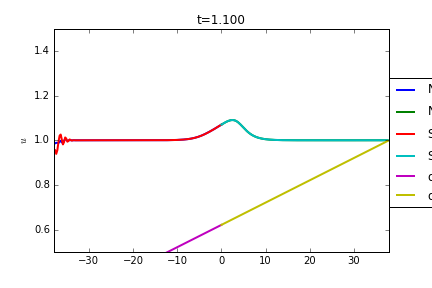
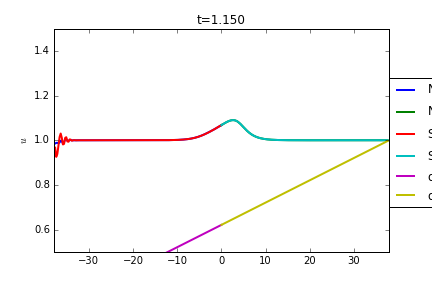
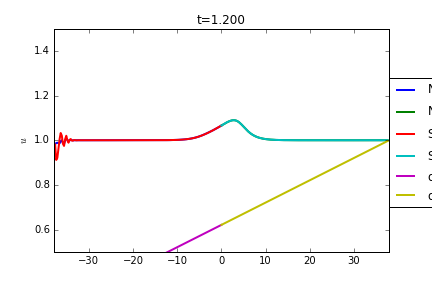
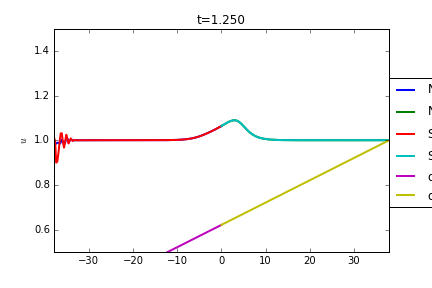
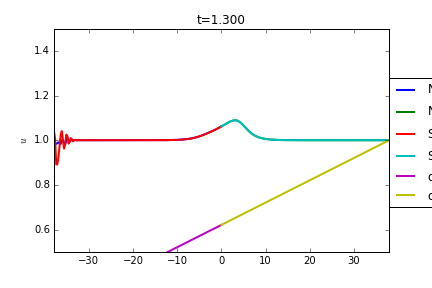
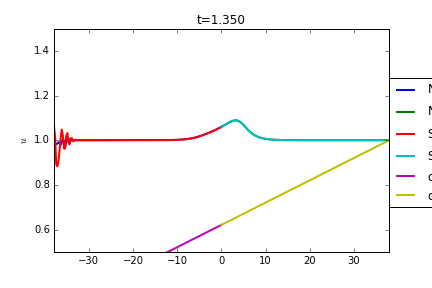
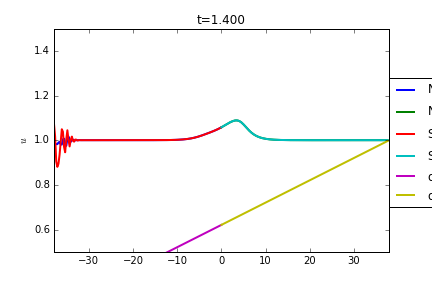
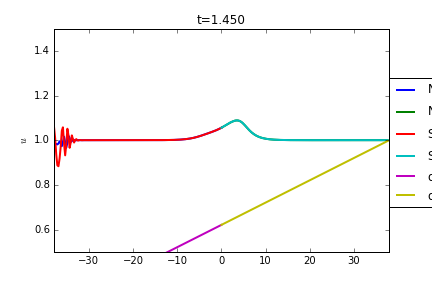
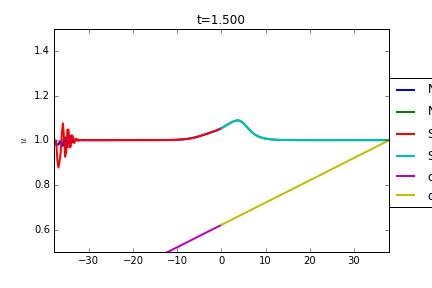
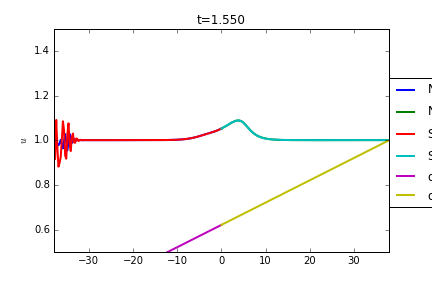
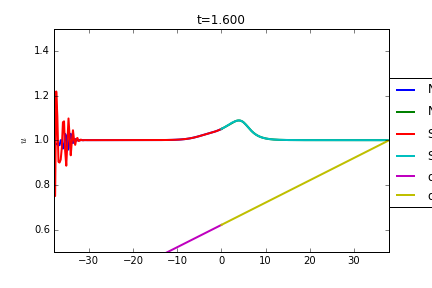
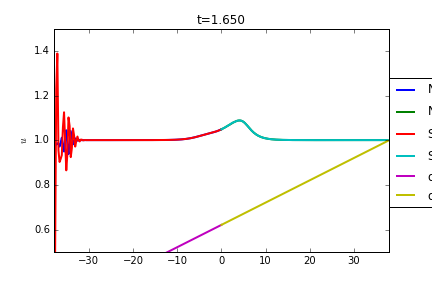
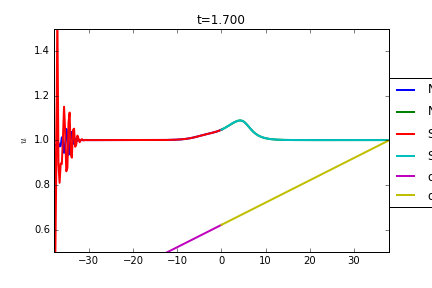
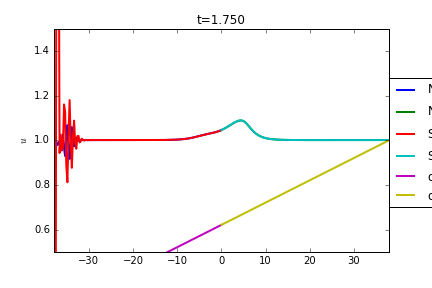
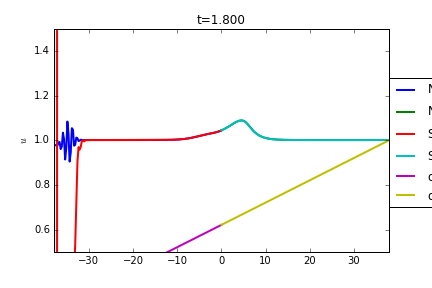
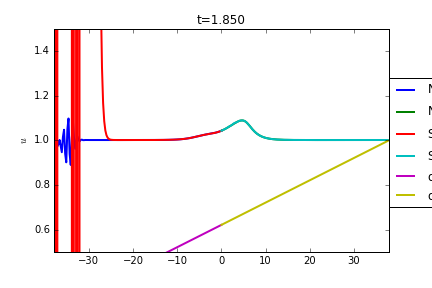
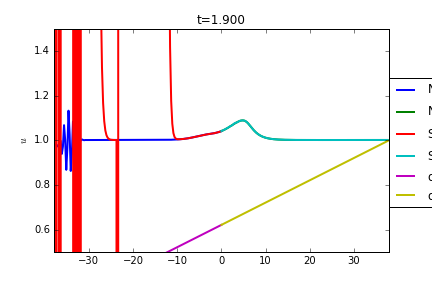
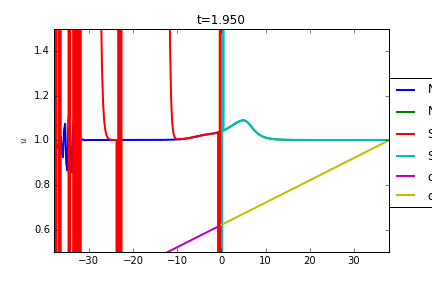
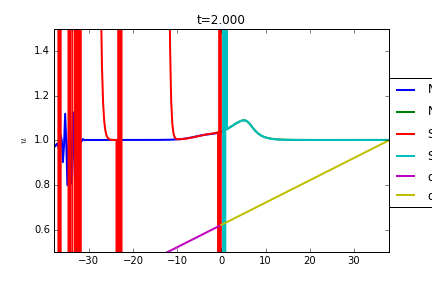
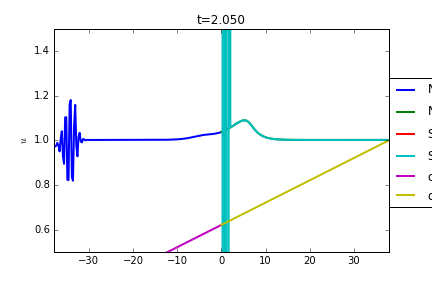
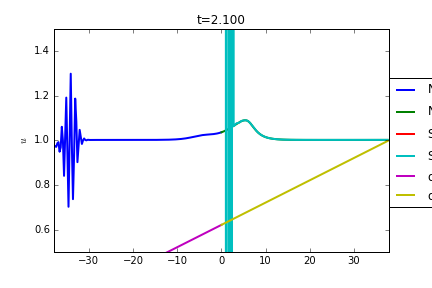
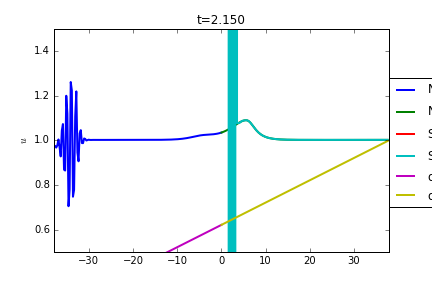
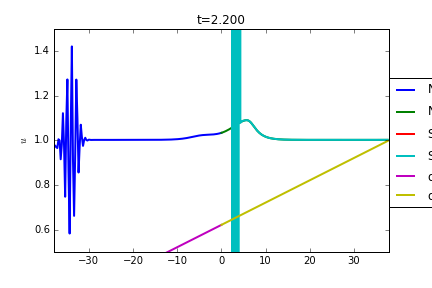
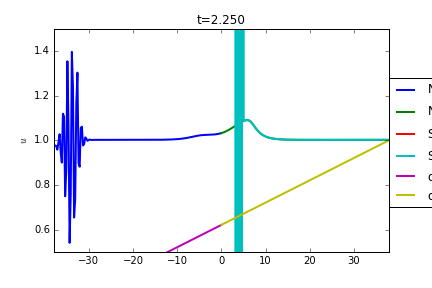
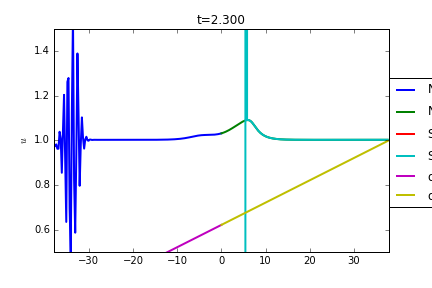
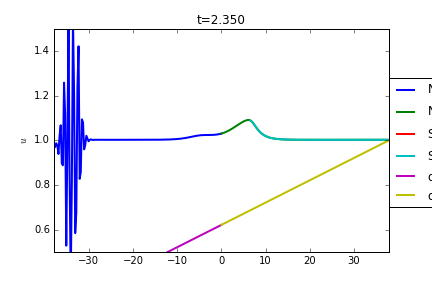
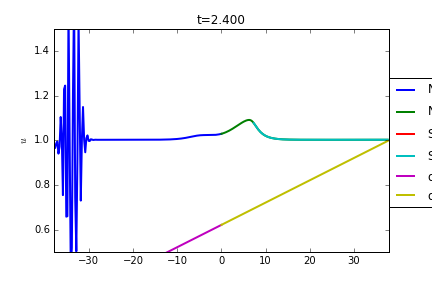
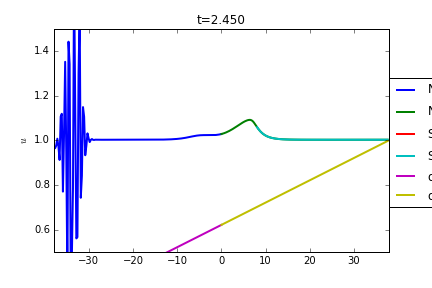
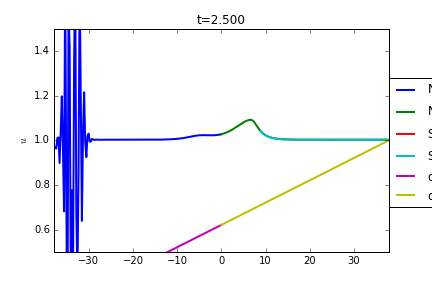
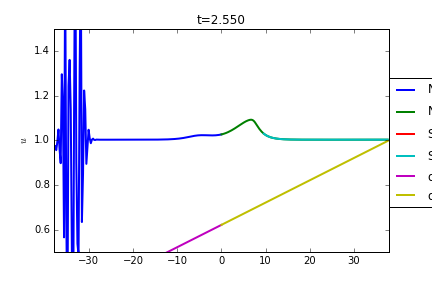
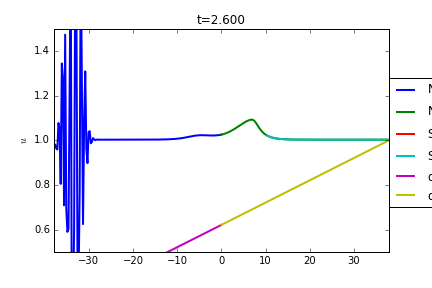
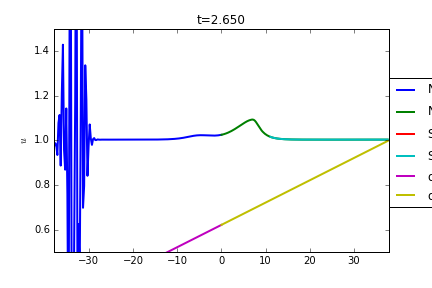
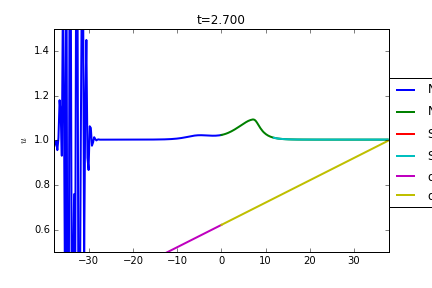
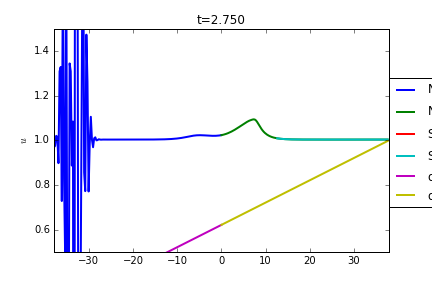
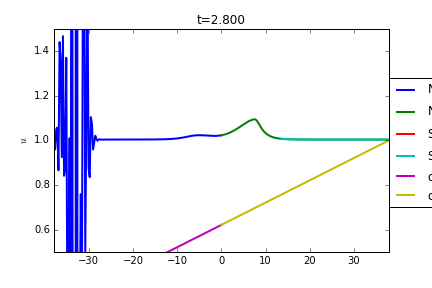
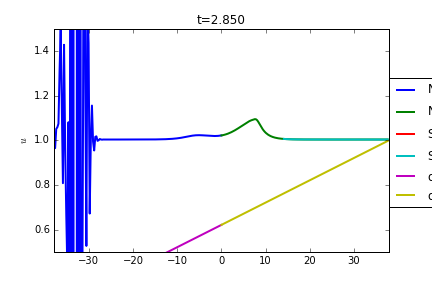
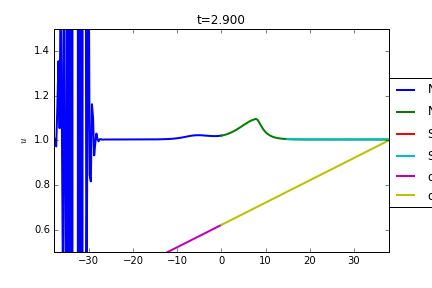
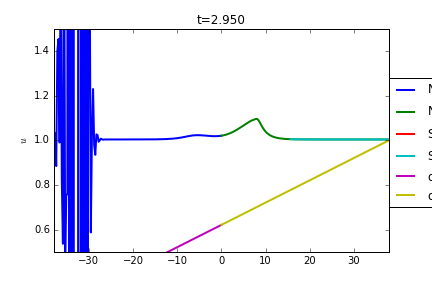
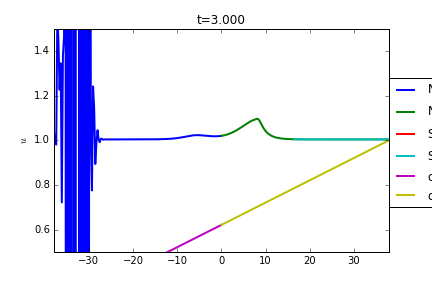
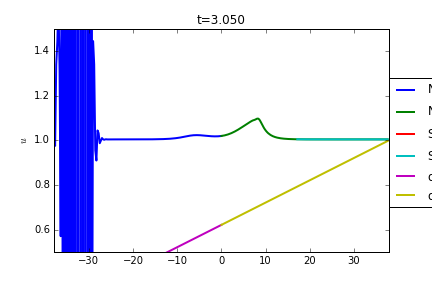

In [247]:
lb = ["NSWE ($\Omega_1$)","NSWE ($\Omega_2$)", "SerrexNSWE ($\Omega_1$)", "SerrexNSWE ($\Omega_2$)","d0","d0"]
gF.plotAnimationNSolutionsDiffDomain(6,np.array([x1P,x2P,x1DLP,x2DLP,x1P,x2P]),
                                     np.array([hall1P,hall2P,hall1DLP,hall2DLP,d0all1DLP,d0all2DLP]),
                                     tall1DL,xmin,xmax,0.5,1.5,lb,ylabel=r'$u$',location=(1.,0.2))